In [1]:
from transformers import RobertaModel, RobertaTokenizerFast

tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")

In [2]:
import json


all_spans = {}

with open("../../mfc_v4.0/spans_with_context.json", "r") as f:
    all_spans = json.load(f)
    
articles = all_spans["articles"]
spans = all_spans["spans"]

a_deleted = 0
for article in list(articles.keys()):
    if len(tokenizer(articles[article])['input_ids']) >= 512:
        del articles[article]
        a_deleted += 1
        
s_deleted = 0
filtered_spans = []
for span in spans:
    if span[-1] not in articles:
        s_deleted += 1
        continue
    filtered_spans.append(span)
    
spans = filtered_spans
labels = set(e[0] for e in spans)

print("Deleted {} articles and {} spans to fit bert input size".format(a_deleted, s_deleted))

Token indices sequence length is longer than the specified maximum sequence length for this model (3016 > 512). Running this sequence through the model will result in indexing errors


Deleted 321 articles and 8147 spans to fit bert input size


In [3]:
import torch
import torch.nn as NN
from torch.nn.functional import normalize


class FullContextSpanClassifier(NN.Module):
    def __init__(self, labels, reporting=False):
        
        super().__init__()
        self.transformer = RobertaModel.from_pretrained("roberta-base")
        for params in self.transformer.parameters():
            params.requires_grad = False
        self.transformer.eval()
        self.fc = NN.Linear(768, len(labels))
        self.logits = NN.Softmax()
        self.labels = labels
        self.reporting=reporting
    
    def forward(self, x):
        tokens = x[0]
        indices = x[1]
        dims = list(indices.shape)
        indices = torch.flatten(indices)
        
        self.report("Data unpacked. running bigbird...")
        
        x = self.transformer(**tokens).last_hidden_state
        
        self.report("bigbird run. applying mask and summing...")
        
        x = torch.reshape(x, (dims[0]*dims[1], 768))
        self.report("mask shape:", indices.shape, "data shape:", x.shape)
        
        x = (x.t()*indices).t()
        self.report("after masking, data is of shape", x.shape)
        x = torch.reshape(x, (dims[0], dims[1], 768))
        
        x = torch.sum(x, dim=1)
        self.report("after summing, data is of shape", x.shape)
        
        x = normalize(x, dim=1)
        
        x = self.fc(x)
        
        x = self.logits(x)
        
        self.report("classifier run.")
        
        return x
    
    def report(self,*args):
        if self.reporting:
            print("(FullContextSpanClassifier): ", " ".join([str(x) for x in args]))

In [4]:
import random

In [5]:
def calc_annotation_mask(offset_mapping, batch_bounds):
    token_spans = []
    for i, inp in enumerate(offset_mapping):

        start_idx = -1
        end_idx = -1

        for j, span in enumerate(inp):
            tok_start = span[0]
            tok_end = span[1]
            annotation_start = batch_bounds[i][0]
            annotation_end = batch_bounds[i][1]
            if tok_end > annotation_start and start_idx == -1:
                start_idx = j
            if tok_end > annotation_end:
                end_idx = j
                break
        token_spans.append([1 if i >= start_idx and i < end_idx else 0 for i in range(len(inp))])
    return token_spans

In [9]:
import time


subset_size = 5000

data = spans[:subset_size]

batch_size = 16

keys = [float(i+1) for i in range(15)]

data = [ [[1 if i == d[0] else 0 for i in keys],d[1],d[2],d[3]] for d in data]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

random.shuffle(data)

loss_fn = torch.nn.MSELoss(reduction='sum')
learning_rate = 5e-4

model = FullContextSpanClassifier(list(labels)).to(device)
model.train()

train_losses = []
test_losses = []

optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)


test_x = [d[1:] for d in data[:batch_size]]
test_x_tokens = tokenizer([articles[x[-1]] for x in test_x], padding=True, return_offsets_mapping=True, return_tensors='pt')
test_annotation_mask = calc_annotation_mask(test_x_tokens["offset_mapping"], test_x)
test_slice_tensor = torch.tensor(test_annotation_mask, dtype=torch.float)
del test_x_tokens["offset_mapping"]
test_model_input = [test_x_tokens.to(device), test_slice_tensor.to(device)]

test_y = torch.tensor([d[0] for d in data[:batch_size]], dtype=torch.float).to(device)

train_data = data[batch_size:]

for epoch in range(5):
    
    print("Starting training epoch", epoch)
    
    random.shuffle(train_data)

    train_x = [d[1:] for d in train_data]
    train_y = [d[0] for d in train_data]

    x_batches = []
    y_batches = []
    
    print("constructing batches...")
    
    for i in range(len(train_data)//batch_size):
        batch_x = train_x[i*batch_size:(i+1)*batch_size]
        batch_y = torch.tensor(train_y[i*batch_size:(i+1)*batch_size], dtype=torch.float).to(device)
        x_batches.append(batch_x)
        y_batches.append(batch_y)
    
    t1 = time.time()
    print("batches constructed. starting training steps...")

    for step in range(len(x_batches)):
        
        #print("tokenizing batch {} of {}...".format(step, len(x_batches)))
        
        batch_tokens = tokenizer([articles[x[-1]] for x in x_batches[step]], padding=True, truncation=True, return_offsets_mapping=True, return_tensors='pt')
        
        #print("tokenized. calculating annotation mask...")
        
        annotation_mask = calc_annotation_mask(batch_tokens["offset_mapping"], x_batches[step])
        slice_tensor = torch.tensor(annotation_mask, dtype=torch.float)
        del batch_tokens["offset_mapping"]
        model_input = [batch_tokens.to(device), slice_tensor.to(device)]
        
        #print("mask calculated. running model...")
        
#         with torch.no_grad():
#             embeddings = model(model_input).detach().cpu().numpy().astype('float32')
#         all_embeddings.append(embeddings)
        y_train_pred = model(model_input)
        train_loss = loss_fn(y_train_pred, y_batches[step])
        
        train_losses.append(train_loss.item())

        print("Training Loss at step",step,":",train_loss.item())

        optimizer.zero_grad()

        train_loss.backward()

        optimizer.step()

        if step % 10 == 0:
            y_test_pred = model(test_model_input)
            test_loss = loss_fn(y_test_pred, test_y).item()
            test_losses.append(test_loss)
            print("Test Loss",test_loss,"\n")
            
            diff = time.time() - t1
            proj_end = (diff/(step+1)) * len(x_batches)
            print("done with step {} of {}".format(step, len(x_batches)))
            print("current time:", diff/60, "est epoch finish: ", proj_end/60)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/sam/.local/lib/python3.6/site-packages/ipykernel_launcher.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Starting training epoch 0
constructing batches...
batches constructed. starting training steps...
Training Loss at step 0 : 14.959721565246582
Test Loss 14.867717742919922 

done with step 0 of 311
current time: 0.011228454113006592 est epoch finish:  3.4920492291450502
Training Loss at step 1 : 14.894336700439453
Training Loss at step 2 : 14.858057975769043
Training Loss at step 3 : 14.871723175048828
Training Loss at step 4 : 14.857890129089355
Training Loss at step 5 : 14.851085662841797
Training Loss at step 6 : 14.791114807128906
Training Loss at step 7 : 14.797819137573242
Training Loss at step 8 : 14.750685691833496
Training Loss at step 9 : 14.730365753173828
Training Loss at step 10 : 14.79826545715332
Test Loss 14.77617073059082 

done with step 10 of 311
current time: 0.07496475378672282 est epoch finish:  2.1194580388791633
Training Loss at step 11 : 14.66836166381836
Training Loss at step 12 : 14.718295097351074
Training Loss at step 13 : 14.719673156738281
Training Loss a

Training Loss at step 138 : 14.141304969787598
Training Loss at step 139 : 13.964757919311523
Training Loss at step 140 : 13.989887237548828
Test Loss 14.484991073608398 

done with step 140 of 311
current time: 0.9137767990430196 est epoch finish:  2.015493507109072
Training Loss at step 141 : 14.272119522094727
Training Loss at step 142 : 14.026771545410156
Training Loss at step 143 : 14.262874603271484
Training Loss at step 144 : 13.904277801513672
Training Loss at step 145 : 13.968494415283203
Training Loss at step 146 : 14.079180717468262
Training Loss at step 147 : 14.188714981079102
Training Loss at step 148 : 14.207623481750488
Training Loss at step 149 : 14.084989547729492
Training Loss at step 150 : 13.898887634277344
Test Loss 14.469326972961426 

done with step 150 of 311
current time: 0.9755862792332967 est epoch finish:  2.0093200850434125
Training Loss at step 151 : 14.138829231262207
Training Loss at step 152 : 13.954305648803711
Training Loss at step 153 : 14.029413223

Training Loss at step 275 : 13.759088516235352
Training Loss at step 276 : 13.976300239562988
Training Loss at step 277 : 14.11009693145752
Training Loss at step 278 : 13.846817016601562
Training Loss at step 279 : 13.529170989990234
Training Loss at step 280 : 14.044897079467773
Test Loss 14.435081481933594 

done with step 280 of 311
current time: 1.819424311319987 est epoch finish:  2.0136688997171386
Training Loss at step 281 : 13.88992977142334
Training Loss at step 282 : 13.429948806762695
Training Loss at step 283 : 13.854198455810547
Training Loss at step 284 : 12.915481567382812
Training Loss at step 285 : 13.7476806640625
Training Loss at step 286 : 14.205766677856445
Training Loss at step 287 : 13.832663536071777
Training Loss at step 288 : 13.262690544128418
Training Loss at step 289 : 13.662324905395508
Training Loss at step 290 : 13.929732322692871
Test Loss 14.420700073242188 

done with step 290 of 311
current time: 1.8861392339070637 est epoch finish:  2.01577079637490

Training Loss at step 101 : 13.081175804138184
Training Loss at step 102 : 13.608415603637695
Training Loss at step 103 : 13.568195343017578
Training Loss at step 104 : 13.751971244812012
Training Loss at step 105 : 13.440061569213867
Training Loss at step 106 : 13.408931732177734
Training Loss at step 107 : 13.024662017822266
Training Loss at step 108 : 12.553852081298828
Training Loss at step 109 : 12.523609161376953
Training Loss at step 110 : 13.171409606933594
Test Loss 14.427536010742188 

done with step 110 of 311
current time: 0.7408387581507365 est epoch finish:  2.075683367431343
Training Loss at step 111 : 13.76736068725586
Training Loss at step 112 : 14.42209243774414
Training Loss at step 113 : 12.77018928527832
Training Loss at step 114 : 13.640714645385742
Training Loss at step 115 : 13.607872009277344
Training Loss at step 116 : 13.017206192016602
Training Loss at step 117 : 13.498541831970215
Training Loss at step 118 : 13.130196571350098
Training Loss at step 119 : 13

Test Loss 14.445720672607422 

done with step 240 of 311
current time: 1.6101922591527302 est epoch finish:  2.077882956831947
Training Loss at step 241 : 13.958657264709473
Training Loss at step 242 : 11.826604843139648
Training Loss at step 243 : 13.099632263183594
Training Loss at step 244 : 13.531580924987793
Training Loss at step 245 : 12.88785171508789
Training Loss at step 246 : 13.23388957977295
Training Loss at step 247 : 13.044831275939941
Training Loss at step 248 : 12.97305965423584
Training Loss at step 249 : 13.947416305541992
Training Loss at step 250 : 13.702718734741211
Test Loss 14.447389602661133 

done with step 250 of 311
current time: 1.6765708724657695 est epoch finish:  2.0773447862026067
Training Loss at step 251 : 12.810556411743164
Training Loss at step 252 : 12.394550323486328
Training Loss at step 253 : 12.547500610351562
Training Loss at step 254 : 13.24925708770752
Training Loss at step 255 : 12.890790939331055
Training Loss at step 256 : 14.3735923767089

Training Loss at step 64 : 12.83047103881836
Training Loss at step 65 : 13.076187133789062
Training Loss at step 66 : 13.783448219299316
Training Loss at step 67 : 12.406609535217285
Training Loss at step 68 : 14.17767333984375
Training Loss at step 69 : 13.489090919494629
Training Loss at step 70 : 12.72929859161377
Test Loss 14.506133079528809 

done with step 70 of 311
current time: 0.4708092411359151 est epoch finish:  2.062277098496755
Training Loss at step 71 : 13.181140899658203
Training Loss at step 72 : 13.677448272705078
Training Loss at step 73 : 13.361368179321289
Training Loss at step 74 : 12.37997055053711
Training Loss at step 75 : 13.447749137878418
Training Loss at step 76 : 13.247318267822266
Training Loss at step 77 : 11.632349967956543
Training Loss at step 78 : 12.633420944213867
Training Loss at step 79 : 13.67714786529541
Training Loss at step 80 : 13.982742309570312
Test Loss 14.514778137207031 

done with step 80 of 311
current time: 0.5366899212201436 est epoc

Training Loss at step 202 : 14.572595596313477
Training Loss at step 203 : 13.59028434753418
Training Loss at step 204 : 13.331632614135742
Training Loss at step 205 : 12.138372421264648
Training Loss at step 206 : 14.118921279907227
Training Loss at step 207 : 11.309013366699219
Training Loss at step 208 : 12.205883026123047
Training Loss at step 209 : 13.460623741149902
Training Loss at step 210 : 12.777891159057617
Test Loss 14.509445190429688 

done with step 210 of 311
current time: 1.402266263961792 est epoch finish:  2.066847431716196
Training Loss at step 211 : 12.646352767944336
Training Loss at step 212 : 12.905194282531738
Training Loss at step 213 : 13.198047637939453
Training Loss at step 214 : 11.913836479187012
Training Loss at step 215 : 12.618432998657227
Training Loss at step 216 : 12.674047470092773
Training Loss at step 217 : 12.224212646484375
Training Loss at step 218 : 13.84684944152832
Training Loss at step 219 : 13.12644100189209
Training Loss at step 220 : 12.

Training Loss at step 27 : 13.610698699951172
Training Loss at step 28 : 12.461273193359375
Training Loss at step 29 : 12.013086318969727
Training Loss at step 30 : 13.557920455932617
Test Loss 14.502076148986816 

done with step 30 of 311
current time: 0.21086597045262653 est epoch finish:  2.1154618326053822
Training Loss at step 31 : 13.977310180664062
Training Loss at step 32 : 12.708261489868164
Training Loss at step 33 : 14.162622451782227
Training Loss at step 34 : 12.614825248718262
Training Loss at step 35 : 12.785511016845703
Training Loss at step 36 : 12.876684188842773
Training Loss at step 37 : 11.471185684204102
Training Loss at step 38 : 12.360395431518555
Training Loss at step 39 : 12.785368919372559
Training Loss at step 40 : 12.071310997009277
Test Loss 14.499242782592773 

done with step 40 of 311
current time: 0.2786492705345154 est epoch finish:  2.113656661859373
Training Loss at step 41 : 12.071365356445312
Training Loss at step 42 : 13.062594413757324
Training L

Training Loss at step 166 : 12.16242504119873
Training Loss at step 167 : 14.092852592468262
Training Loss at step 168 : 13.58592414855957
Training Loss at step 169 : 12.82476806640625
Training Loss at step 170 : 11.981552124023438
Test Loss 14.422200202941895 

done with step 170 of 311
current time: 1.1334516684214273 est epoch finish:  2.061423794614409
Training Loss at step 171 : 12.989645004272461
Training Loss at step 172 : 14.505607604980469
Training Loss at step 173 : 12.13363265991211
Training Loss at step 174 : 14.361852645874023
Training Loss at step 175 : 10.738110542297363
Training Loss at step 176 : 12.778749465942383
Training Loss at step 177 : 13.304718971252441
Training Loss at step 178 : 12.961150169372559
Training Loss at step 179 : 14.002437591552734
Training Loss at step 180 : 13.125179290771484
Test Loss 14.40896987915039 

done with step 180 of 311
current time: 1.1996949752171835 est epoch finish:  2.061354349682564
Training Loss at step 181 : 12.590780258178711

Training Loss at step 304 : 11.517258644104004
Training Loss at step 305 : 10.691617965698242
Training Loss at step 306 : 13.69145679473877
Training Loss at step 307 : 12.121540069580078
Training Loss at step 308 : 12.093564987182617
Training Loss at step 309 : 12.956635475158691
Training Loss at step 310 : 12.824211120605469
Test Loss 14.327960968017578 

done with step 310 of 311
current time: 2.0454909642537435 est epoch finish:  2.0454909642537435
Starting training epoch 4
constructing batches...
batches constructed. starting training steps...
Training Loss at step 0 : 13.52159309387207
Test Loss 14.407410621643066 

done with step 0 of 311
current time: 0.011130237579345703 est epoch finish:  3.4615038871765136
Training Loss at step 1 : 13.75076675415039
Training Loss at step 2 : 12.319293975830078
Training Loss at step 3 : 12.660737991333008
Training Loss at step 4 : 12.147886276245117
Training Loss at step 5 : 13.71452808380127
Training Loss at step 6 : 12.600147247314453
Traini

Test Loss 14.331729888916016 

done with step 130 of 311
current time: 0.8612980763117473 est epoch finish:  2.044761081930942
Training Loss at step 131 : 10.322671890258789
Training Loss at step 132 : 13.11650276184082
Training Loss at step 133 : 12.573434829711914
Training Loss at step 134 : 11.749130249023438
Training Loss at step 135 : 12.863698959350586
Training Loss at step 136 : 11.460198402404785
Training Loss at step 137 : 11.24962043762207
Training Loss at step 138 : 12.231934547424316
Training Loss at step 139 : 13.144277572631836
Training Loss at step 140 : 13.696168899536133
Test Loss 14.340024948120117 

done with step 140 of 311
current time: 0.9278130610783895 est epoch finish:  2.0464529219530436
Training Loss at step 141 : 12.825197219848633
Training Loss at step 142 : 11.013589859008789
Training Loss at step 143 : 12.330129623413086
Training Loss at step 144 : 13.558076858520508
Training Loss at step 145 : 12.461968421936035
Training Loss at step 146 : 10.48080062866

Training Loss at step 268 : 11.842268943786621
Training Loss at step 269 : 14.439458847045898
Training Loss at step 270 : 12.698442459106445
Test Loss 14.309755325317383 

done with step 270 of 311
current time: 1.792059353987376 est epoch finish:  2.05656995974197
Training Loss at step 271 : 12.564315795898438
Training Loss at step 272 : 11.256902694702148
Training Loss at step 273 : 12.269036293029785
Training Loss at step 274 : 12.185663223266602
Training Loss at step 275 : 12.357847213745117
Training Loss at step 276 : 13.10462760925293
Training Loss at step 277 : 13.103679656982422
Training Loss at step 278 : 11.546937942504883
Training Loss at step 279 : 11.8087158203125
Training Loss at step 280 : 12.84669303894043
Test Loss 14.295166015625 

done with step 280 of 311
current time: 1.8559096654256184 est epoch finish:  2.054049487357179
Training Loss at step 281 : 13.00103759765625
Training Loss at step 282 : 11.135763168334961
Training Loss at step 283 : 13.331686019897461
Trai

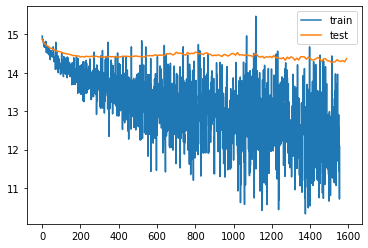

In [10]:
from matplotlib import pyplot as plt

train_domain = list(range(len(train_losses)))
test_domain = ([i*10 for i in range(len(test_losses))])

plt.plot(train_domain, train_losses, label="train")
plt.plot(test_domain, test_losses, label="test")

plt.legend()

plt.show()

In [11]:
torch.save(model.state_dict(), "./distilberta-mfc-with-context.pt")

In [12]:
model_reloaded = FullContextSpanClassifier(labels)
model_reloaded.load_state_dict(torch.load("./distilberta-mfc-with-context.pt"))

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

In [9]:
lengths

{1: 0,
 2: 0,
 4: 0,
 8: 0,
 16: 0,
 32: 0,
 64: 20,
 128: 2092,
 256: 29581,
 512: 240,
 1024: 75,
 2048: 6,
 4096: 0,
 8192: 0}